# Individual Assignment - Classification

**----- Import all libraries here -----**

In [16]:
# data manipulation
import pandas as pd
import numpy as np

# visualiation
import seaborn as sb
import matplotlib.pyplot as plt
# model training
#在下文对应处import了

# classifiers
#在下文对应处import了

#metrics|
#在下文对应处import了

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)

# 1. Data Analysis 

<span style="color:blue">Load the CSV file into a *DataFrame* object named **pima** using Pandas to examine the dataset and perform data cleaning:</span>
    
<span style="color:blue">1) Print the dtype of each column to review the data types of the attributes in the dataset. *(2 points)*</span>

In [17]:
# --- Your code here ---
pima = pd.read_csv('./diabetes.csv')
print(pima.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             767 non-null    float64
 3   SkinThickness             767 non-null    float64
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  767 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 54.1 KB
None


<span style="color:blue">2) Are there any missing values in the dataset? Print out the total count of missing values for the attributes in the dataset. How would you handle the missing values without deleting any record? Develop and execute an operation for that purpose accordingly. *(3 points)*</span>

In [18]:
pima[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] =\
pima[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
gp0 = pima.groupby('Outcome').get_group(0)
gp1 = pima.groupby('Outcome').get_group(1)


df0 = gp0.fillna(gp0.median())
df1 =  gp1.fillna(gp1.median())

pima = df0.append(df1).sort_index(0)

pima.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 60.0 KB


<span style="color:blue">--- Your answer here ---</span>

我使用的是这一列的中位数来填充缺失值。(具体地，分别按糖尿病和非糖尿病数据的中位数填充)。因为我测试了均值效果没中位数好。
<span style="color:black"> </span>

<span style="color:blue">3) Examine Outcome by generating a bar plot showing the count of “0” and “1” in Outcome. Write down any of your insights from observing the bar plot. *(3 points)*</span>

0    500
1    268
Name: Outcome, dtype: int64


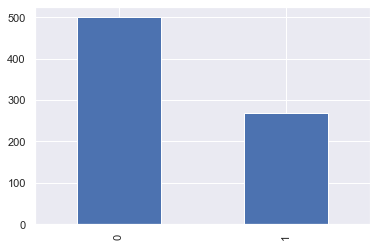

In [19]:
# --- Your code here ---
sb.set(style='darkgrid')
#df1=sb.melt(pima)
# pima['Outcome'].plot.bar()
pima['Outcome'].value_counts().plot(kind='bar')
print(pima['Outcome'].value_counts())

<span style="color:blue">--- Your answer here ---</span>

数据集的类别有点不太均衡，非糖尿病类别的大约是糖尿病类别的两倍。可以考虑采样过采样策略来缓解该问题。

<span style="color:black"> </span>

<span style="color:blue">4) Generate a pairwise relationship scatterplot (8x8 subplots) using __sb.pairplot(pima, vars=feature_column_names, hue='Outcome')__. *(2 points)*</span>

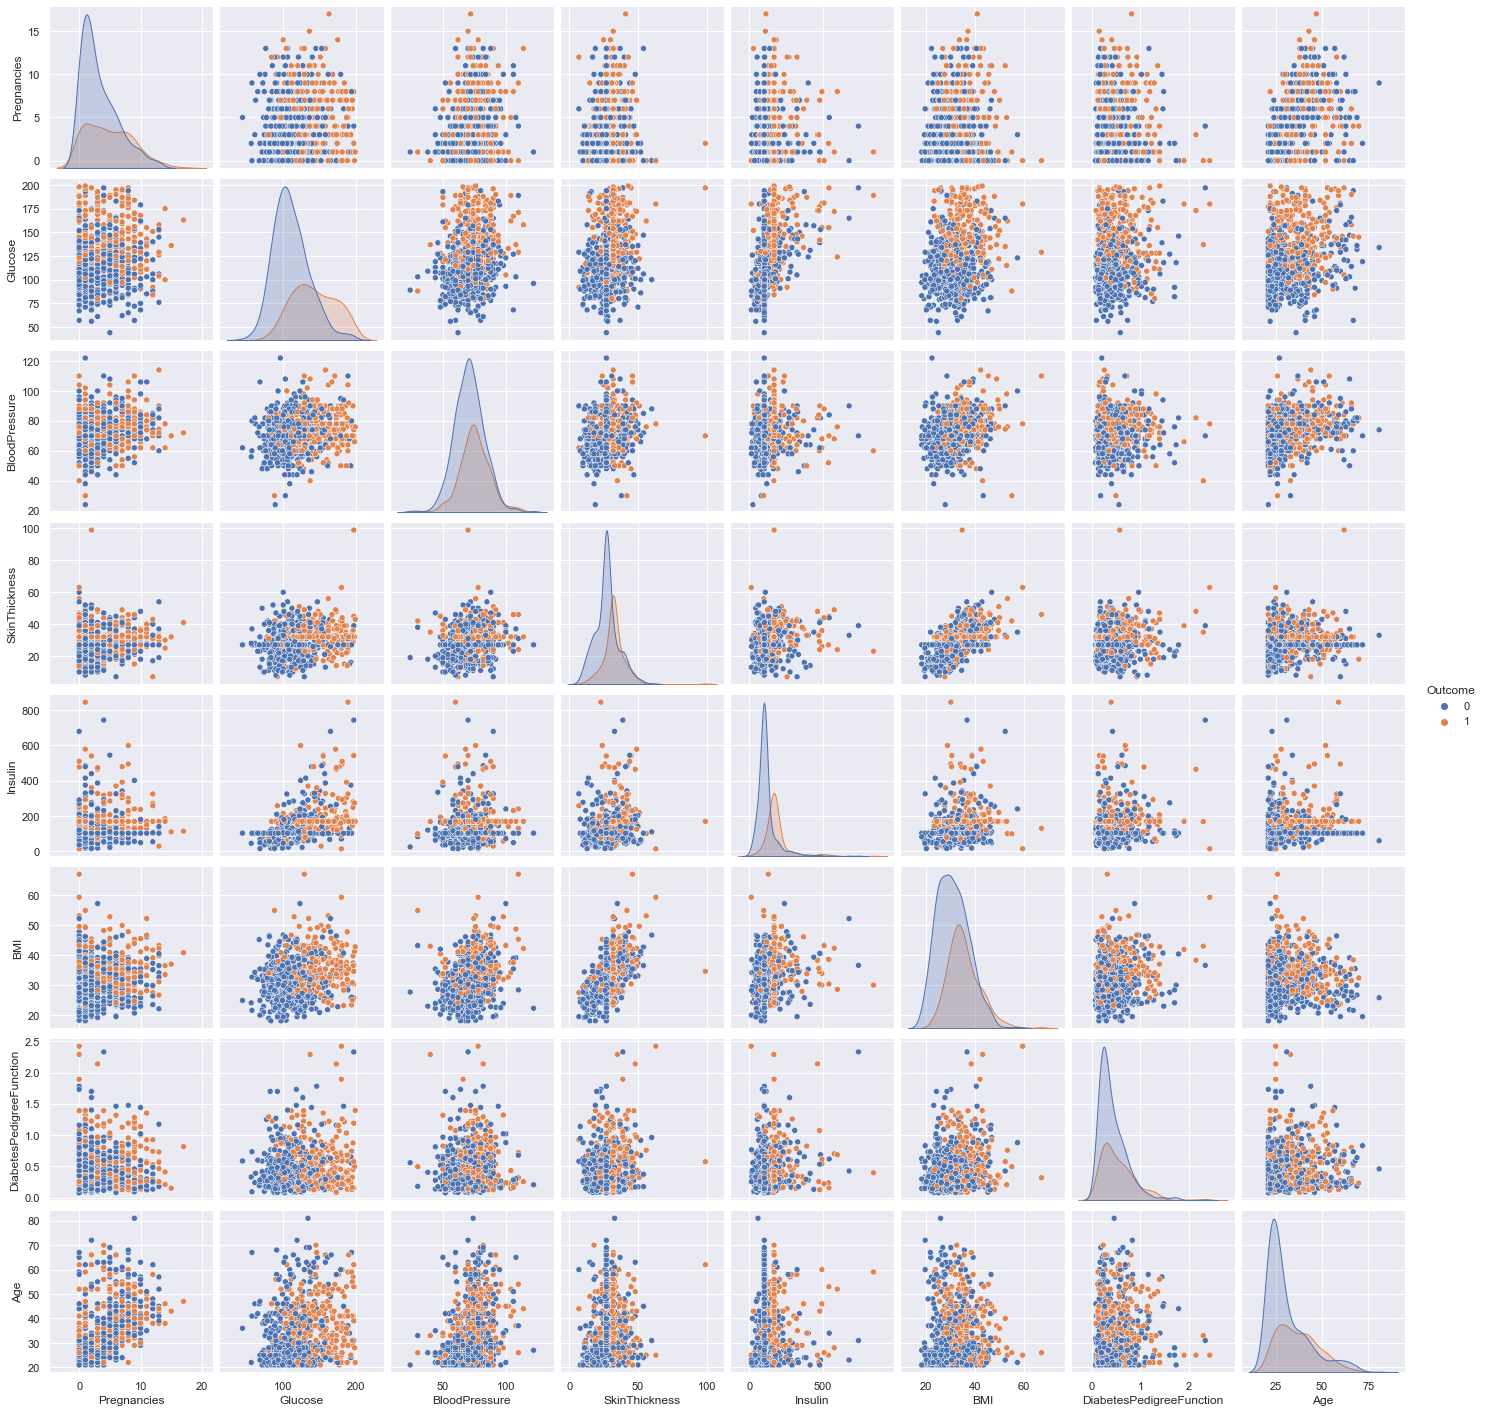

In [20]:
# --- Your code here ---
sb.pairplot(pima, vars=list(pima.columns).remove('Outcome'), hue='Outcome',diag_kind="kde")

<span style="color:blue">5) Generate a 9x9 heatmap plot showing the co-variance between any two features (including target). *(2 points)*<br/>
    
<span style="color:blue">_(Hint: use __sb.clustermap(pima.corr(), annot=True)__ to plot co-variance heatmap.)_</span>

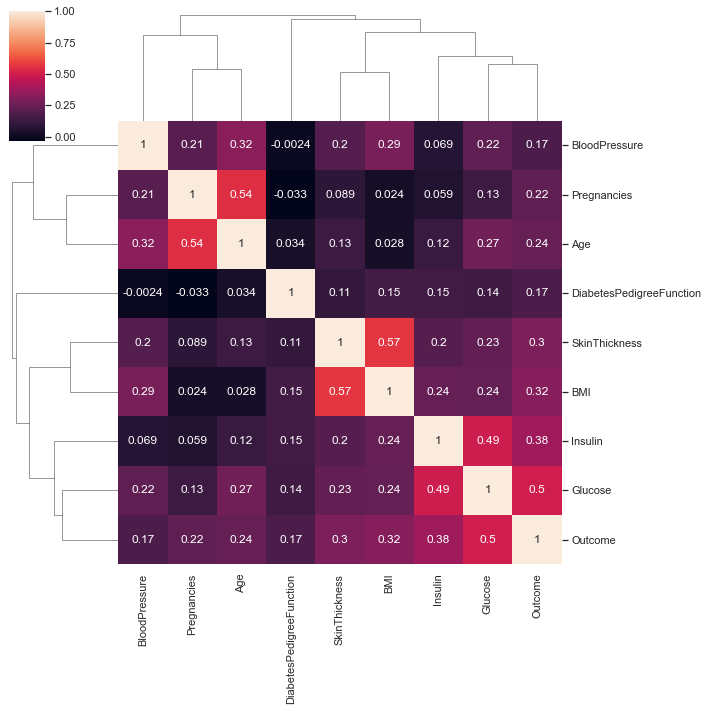

In [21]:
# --- Your code here ---
sb.clustermap(pima.corr(), annot=True)

<span style="color:blue">6) What are the insights you gained from the two plots generated from 4) and 5)? *(3 points)*</span>

<span style="color:blue">_(Hint: think about how to perform feature selection based on the observations, which may be helpful for constructing your best model in Section 4.)_</span>

<span style="color:blue">--- Your answer here ---</span>

&emsp;从上图可以看出，Pregnancies和BloodPressure这两项特征和其他特征的数据对类别的区分度并不明显，如Pregnancies和其他特征的分布图中，正类和负类区分的并不明显，说明可能该项特征对正负类的区分帮助不大，所以可以考虑将这类特征去除，在模型训练阶段对比下去除前后的结果。

&emsp;同时通过上图，在研究多变量之间的关系时，主要从两种关系出发：

1.自变量与自变量之间的相关性：相关性越高，会引发多重共线性问题，进而导致模型稳定性变差，样本微小扰动都会带来大的的参数变化，建议具有共线性的特征选择其中一个即可，其余剔除。

2.自变量与因变量之间的关系：相关性越高，说明特征对模型预测目标更重要，建议保留。


# 2. Feature Transformation

We observe that all the variables in the dataset except the target variable *Outcome* are continuous. In this section, you will perform feature transformation on the continuous variables to generate two sets of features that will be used in the subsequent classification task.

**Feature set 1 - Continuous to Categorical**

<span style="color:blue">1) Often when dealing with continuous variables like *BMI* or *BloodPressure*,  we may wish  to transform these continuous variables into categorical variables, which may be better predictors of *Outcome*. This transformation can be achieved as follows: cut the continuous values of each feature into non-overlapping buckets.  Perform this operation on all 8 continuous variables.  You are to devise you own method to cut the continuous values into buckets. Name the resulting DataFrame as __pima1__. pima1 should still contains 9 conlumns with the same set of column names as pima. Use **pima1.head()** to show the top rows. *(5 points)*</span>
    
<span style="color:blue">*(Hint: you can use **pandas.cut()** or **pandas.qcut()** to convert continuous feature to categorical feature. e.g. For Glucose, if you wish to adopt the glucose level guidelines given by American Diabetes Association, you can convert its values into 3 groups:<br/>*
*- Normal > 140mg/dl of glucose,<br/>*
*- Prediabete 140-199mg/dl of glucose,<br/>*
*- Diabetes > 200mg/dl of glucose<br/>*
*using  **pd.cut(pima[’Glucose’],[50,139.99,199.99,250], labels=[0, 1, 2])**. Or you can use **pd.qcut(pima[’Glucose’],4, labels=[0,1,2,3])** to cut the values according to quantile-based discretization function.)*
</span>

In [22]:
# --- Your code here ---
pima1 = pd.DataFrame()
# pima1['Pregnancies'] = pd.qcut(pima['Pregnancies'], 4, labels=[0,1,2,3])
pima1['Glucose'] = pd.qcut(pima['Glucose'], 4, labels=[0,1,2,3])
pima1['BloodPressure'] = pd.qcut(pima['BloodPressure'], 4, labels=[0,1,2,3])
pima1['SkinThickness'] = pd.cut(pima['SkinThickness'], 4,labels=[0,1,2,3])
pima1['Insulin'] = pd.cut(pima['Insulin'], 4,labels=[0,1,2,3])
pima1['BMI'] = pd.qcut(pima['BMI'], 4, labels=[0,1,2,3])
pima1['DiabetesPedigreeFunction'] = pd.qcut(pima['DiabetesPedigreeFunction'], 4, labels=[0,1,2,3])
pima1['Age'] = pd.qcut(pima['Age'], 4, labels=[0,1,2,3])
pima1['Outcome'] = pima['Outcome'].copy()

In [23]:
pima1.head(5)

Glucose BloodPressure SkinThickness Insulin BMI DiabetesPedigreeFunction  \
0       3             1             1       0   2                        3   
1       0             1             0       0   0                        1   
2       3             0             1       0   0                        3   
3       0             1             0       0   1                        0   
4       2             0             1       0   3                        3   

  Age  Outcome  
0   3        1  
1   2        0  
2   2        1  
3   0        0  
4   2        1

<span style="color:blue">2) Next, we convert the generated categorical features into binary features using the **one-hot encoding scheme**. Assume the continuous feature has m numerical labels. The one-hot encoding scheme will results in a vector of size m with only one of the values as 1 (indicating it as active). Use **pima1.head()** to show the top rows of the encoded pima1. *(2 points)*</span>

<span style="color:blue">*(Hint: you can use **pd.getdummies()** to convert each categorical feature in pima1 into multiple binary features.)*</span>

In [24]:
# --- Your code here ---
pima1 = pd.get_dummies(pima1)
pima1.head(5)

Outcome  Glucose_0  Glucose_1  Glucose_2  Glucose_3  BloodPressure_0  \
0        1          0          0          0          1                0   
1        0          1          0          0          0                0   
2        1          0          0          0          1                1   
3        0          1          0          0          0                0   
4        1          0          0          1          0                1   

   BloodPressure_1  BloodPressure_2  BloodPressure_3  SkinThickness_0  ...  \
0                1                0                0                0  ...   
1                1                0                0                1  ...   
2                0                0                0                0  ...   
3                1                0                0                1  ...   
4                0                0                0                0  ...   

   BMI_2  BMI_3  DiabetesPedigreeFunction_0  DiabetesPedigreeFunction_1  \
0      1      0                           0                           0   
1      0      0                           0                           1   
2      0      0                           0                           0   
3      0      0                           1                           0   
4      0      1                           0                           0   

   DiabetesPedigreeFunction_2  DiabetesPedigreeFunction_3  Age_0  Age_1  \
0                           0                           1      0      0   
1                           0                           0      0      0   
2                           0                           1      0      0   
3                           0                           0      1      0   
4                           0                           1      0      0   

   Age_2  Age_3  
0      0      1  
1      1      0  
2      1      0  
3      0      0  
4      1      0  

[5 rows x 29 columns]

<span style="color:blue">3) Discuss whether the use of one-hot encoding can be omitted and why? *(3 points)*</span>

<span style="color:blue">--- Your answer here ---</span>

&emsp;one hot编码是将类别变量转换为机器学习算法易于利用的一种形式的过程，其解决了分类器不好处理属性数据的问题，在一定程度上也起到了扩充特征的作用。不使用one-hot编码也是可以的，因为不使用one-hot编码，相当于每一条数据有8个特征，每个特征都会有不同的值，这样模型也是可以学习到不同数据之间的关系的。另外，如果原本的标签编码是有序的，那one hot编码就不合适了，会丢失顺序信息。
<span style="color:black"> </span>

**Feature set 2 - Features normalization**

<span style="color:blue">4) For the second feature set, we normalize the values of 8 continuous variables. For each variable, we apply the transformation using the formula **z=(x−u)/s**, where u and s are the mean and standard deviation of the variable values. Name the resulting DataFrame as **pima2**, and show the top rows using pima2.head(). *(2 points)*</span>

<span style="color:blue">*(Hint: you can use **StandardScaler** from scikit-learn for standadization purpose)*</span>

In [25]:
# --- Your code here ---
from sklearn .preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(pima.values[:,:8])
y = pima.values[:,8]
pima2 = pd.DataFrame(x,columns=pima.columns[:8])
pima2['Outcome'] = y
pima2.head(5)

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.639947  0.864625      -0.033502       0.665602  0.311604  0.169483   
1    -0.844885 -1.204727      -0.529890      -0.009672 -0.440843 -0.848549   
2     1.233880  2.014265      -0.695353       0.327965  0.311604 -1.328478   
3    -0.844885 -1.073339      -0.529890      -0.684945 -0.536303 -0.630399   
4    -1.141852  0.503310      -2.680908       0.665602  0.294758  1.551096   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.470007  1.425995      1.0  
1                 -0.363708 -0.190672      0.0  
2                  0.605939 -0.105584      1.0  
3                 -0.919518 -1.041549      0.0  
4                  5.487403 -0.020496      1.0

<span style="color:blue">5) Briefly discuss whether Feature set 1 or Feature set 2 is more useful for training classification models and why? Also comment on whether feature normalization is necessary in this case. *(3 points)*</span>

<span style="color:blue">--- Your answer here ---</span>

  我认为Feature set 2较为有用，因为Feature set 1将数据离散化后分成了有限的几个区间，可能会丢失一些连续型的特征信息。
而Feature set 2是对分别对8个变量数据做了归一化，从而消除了不同变量量纲之间的差异，从而使模型能够更好的学习到这些特征的信息。

通过下面对比实验也确实证明了这一点。

<span style="color:black"> </span>

# 3. Model Construction

Your task in this section is to use the derived feature sets from previous section to construct classification models for diabetes outcome prediction (0 or 1).  We have splitted the data into training and test sets for you as shown below (you need to run the cell below).

In [26]:
pima2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


In [27]:
from sklearn.model_selection import train_test_split
# pima1 split
# Feature set 1
x1 = pima1.drop(columns='Outcome')
y1 = pima1['Outcome']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size = 0.25, random_state=0)

# pima2 split
# Feature set 2
x2 = pima2.drop(columns=['Outcome'])
# x2 = pima2.drop(columns='Outcome')
y2 = pima2['Outcome']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.25, random_state=0)

print(x1.shape, y1.shape)
print(x2.shape, y2.shape)

(768, 28) (768,)
(768, 8) (768,)


In [28]:
# 经过对比我发现，KMeansSMOTE过采样效果比SMOTE 过采样好，所以这里我采用KMeansSMOTE过采样方法
# 只对训练集过采样，测试集不过采样，不然会改变了原有数据分布
from imblearn.over_sampling import KMeansSMOTE
smt =KMeansSMOTE(random_state=42)
x_train1, y_train1 = smt.fit_resample(x_train1, y_train1)
x_train2, y_train2 = smt.fit_resample(x_train2, y_train2)

<span style="color:blue">1) Experiment with the 5 classification models below from scikit-learn with their default hyperparameter settings on pima1 and pima2 (You should thus perform 5x2 times model training and evaluation):<br/></span>

<span style="color:blue">- Gaussian naive bayes</span><br/>
<span style="color:blue">- KNN</span><br/>
<span style="color:blue">- SVM</span><br/>
<span style="color:blue">- logistic regression</span><br/>
<span style="color:blue">- decision tree<br/></span>
    
<span style="color:blue">You should perform model training on x_train1 and x_train2,  and perform evaluation on x_test1 and x_test2 respectively.  Use **accuracy** and **weighted F1** as evaluation metrics, and save the results of different models in the defined lists **pima1_acc**, **pima2_acc**, **pima1_f1**, **pima2_f1**. Note that the order of results in each list should match the model order provided in **model_names**. Print the **accuracy_record** table and **F1_record** table using the provided code. *(20 points)*</span>

In [29]:
from sklearn.metrics import accuracy_score, f1_score
model_names = ['NB','KNN', 'SVM', 'LR', 'DT','MLP','XGB']
pima1_acc = []
pima2_acc = []
pima1_f1 = []
pima2_f1 = []

# --- Your code here ---
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

MODELS = {
          'NB':GaussianNB(),
          'KNN':KNeighborsClassifier(),
          'SVM':SVC(),
          'LR':LogisticRegression(),
          'DT':DecisionTreeClassifier(),
          'MLP':MLPClassifier(),
           'XGB':XGBClassifier()}

model=''
for name in model_names:
    print(name)
    del model
    model = MODELS[name]
    model.fit(x_train1, y_train1)
    y_pred1 = model.predict(x_test1)
    pima1_acc.append(accuracy_score(y_test1, y_pred1))
    pima1_f1.append(f1_score(y_test1, y_pred1, average='weighted'))
    del model
    model = MODELS[name]
    model.fit(x_train2, y_train2)
    y_pred2 = model.predict(x_test2)
    pima2_acc.append(accuracy_score(y_test2, y_pred2))
    pima2_f1.append(f1_score(y_test2, y_pred2, average='weighted'))

m_df = pd.DataFrame({'NB':[],'KNN':[], 'SVM':[], 'LR':[], 'DT':[],'MLP':[],'XGB':[]})
m_df.loc[len(m_df)] = pima1_acc
m_df.loc[len(m_df)] = pima2_acc
m_df.loc[len(m_df)] = pima1_f1
m_df.loc[len(m_df)] = pima2_f1
m_df.index = ['pima1_acc','pima2_acc','pima1_f1','pima2_f1']
m_df

NB
KNN
SVM
LR
DT
MLP
XGB
[10:30:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


NB       KNN       SVM        LR        DT       MLP  \
pima1_acc  0.671875  0.812500  0.677083  0.807292  0.781250  0.838542   
pima2_acc  0.796875  0.828125  0.854167  0.770833  0.854167  0.854167   
pima1_f1   0.544198  0.814612  0.546713  0.809774  0.783714  0.841110   
pima2_f1   0.795515  0.829152  0.855306  0.770833  0.855810  0.854759   

                XGB  
pima1_acc  0.791667  
pima2_acc  0.932292  
pima1_f1   0.794014  
pima2_f1   0.932940

<span style="color:blue">2) According to the results above, which feature set is better, pima1 or pima2? Select one to be used in the following tasks. *(2 points)*</span>

<span style="color:blue">--- Your answer ---</span>

很明显，从以上结果来看，无论是**accuracy** and **weighted F1** as evaluation metrics，feature set 2的指标得分均高于 feature set 1，所以下面任务将基于feature set 2进行实验。

表现性能最优的是XGB集成模型，acc和f1均达到了93%左右。

<span style="color:black"> </span>

<span style="color:blue">3) Select one classification model from 1). Discuss which are the hyperparameters that may affect the model performance the most. Perform grid search with 10 folds cross-validation for tuning those hyperparameters on the training set of either pima1 or pima2 (according to your choice in 2)), using accuracy as the scoring metric. Print the configuration of the best selected model and its prediction **accuracy** and **weighted F1** scores on the corresponding test set. *(15 points)*</span>

<span style="color:blue">*(Hint: for each selected hyperparameter, you need to prepare a list of reasonable values for tunining. Use **sklearn.model_selection.GridSearchCV** for grid search.)*</span>

<span style="color:blue">--- Your choice of hyperparameters here ---</span>
XGBoost的作者把所有的参数分成了三类：

通用参数：宏观函数控制。

Booster参数：控制每一步的booster(tree/regression)。

学习目标参数：控制训练目标的表现。

这里我调试下比较重要的两个参数
<span style="color:black"> </span>

In [32]:
# --- Your code here ---
from sklearn.model_selection import GridSearchCV
param_grid  = {'n_estimators': [100,200,300,400,500],
                'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
                'min_child_weight': [1, 2, 3, 4, 5, 6],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15]}
# param_grid = {
#     'max_depth': [5, 10, 15, 20, 25],
#     'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
#     'n_estimators': [50, 100, 200, 300, 500],
#     'min_child_weight': [0, 2, 5, 10, 20],
#     'max_delta_step': [0, 0.2, 0.6, 1, 2],
#     'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
#     'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
#     'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
#     'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
#     'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1]

# }

xgb_model = XGBClassifier()
grid_search = GridSearchCV(xgb_model, param_grid,n_jobs=-1,verbose=2,cv=10)

grid_search.fit(x_train2,y_train2)
grid_search.best_score_
xgb_model = grid_search.best_estimator_
y_pred2 = xgb_model.predict(x_test2)
acc = accuracy_score(y_test2, y_pred2)
f1 = f1_score(y_test2, y_pred2, average='weighted')
print(acc, f1)
print(xgb_model.get_params())

Fitting 10 folds for each of 1200 candidates, totalling 12000 fits
[10:50:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9114583333333334 0.9125990656649469
{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 500, 'n_jobs': 16, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tre

<span style="color:blue">4) Besides accuracy and F1 scores, one can look at the confusion matrix to understand the model's prediction behaviour. Compare confusion matrix on test data before and after hyperparameter tuning for the selected model in 3). Discuss any of your observations or insights. *(5 points)*</span>

<span style="color:blue">*(Hint: you can use **confusion_matrix** from scikit-learn, and use **sb.heatmap(conf_matrix, annot=True)** to plot a corresponding heatmap for better visualization.)*</span>

Text(0.5, 50.5, '预测结果')

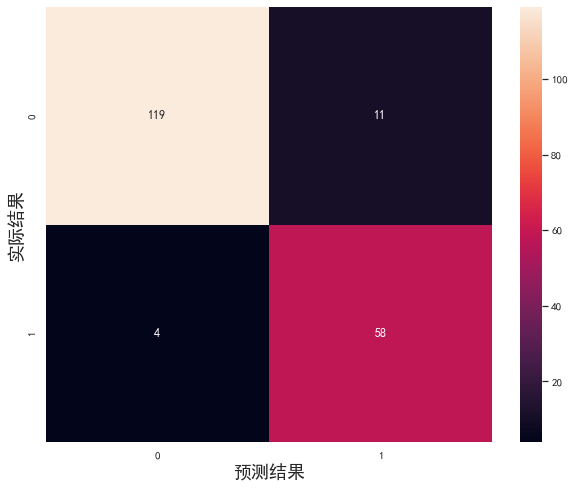

In [302]:
# --- Your code here ---
import seaborn as sns

plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置
from sklearn.metrics import accuracy_score, confusion_matrix
conf_mat = confusion_matrix( y_test2, y_pred2)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=[str(i) for i in range(2)],
            yticklabels=[str(i) for i in range(2)])
plt.ylabel('实际结果',fontsize=18)
plt.xlabel('预测结果',fontsize=18)

<span style="color:blue">--- Your observations here ---</span>

从可视化混淆矩阵的结果可以看出，主对角线值越大，那预测效果就越好。从非对角线上的值可以看出，只有少数假阳性和假阴性预测错误。
<span style="color:black">  </span>

<span style="color:blue">5) You can get feature importances for some tree-based classifiers in scikit-learn via **clf.feature_importances_**. Example code for plotting pima2 feature importances for an adaboost decision tree classifier has been given below. Generate the plot and describe your observations. Briefly describe how the feature importances for the given classifier can be computed. *(5 points)*</span>

0.9114583333333334 0.9123062015503876


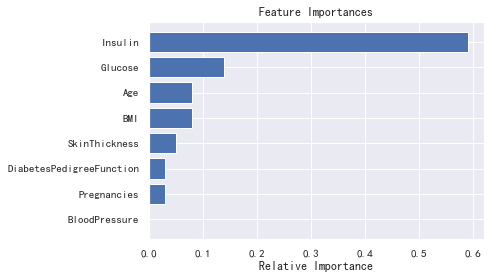

In [303]:
# --- Your code here ---
# build a classifier for ada boost
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

clf_ada = AdaBoostClassifier()
param_dist = {"n_estimators": [10, 100, 200, 400],
              "learning_rate": [0.001, 0.005, .01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 10, 20]}

# Run a randomized search over the hyperparameters
ada_search = RandomizedSearchCV(clf_ada, param_distributions=param_dist)
ada_search.fit(x_train2, y_train2)
y_pred2 = ada_search.best_estimator_.predict(x_test2)
acc = accuracy_score(y_test2, y_pred2)
f1 = f1_score(y_test2, y_pred2, average='weighted')
print(acc, f1)

# Plot feature importances
features = pima2.columns[:pima2.shape[1]]
importances = ada_search.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance');

<span style="color:blue">--- Your description here ---</span>

&emsp;从特征重要性可视化的结果来看，Insulin,Glucose,BMI,Age等指标对模型的学习与预测起到了较为关键的作用。有趣的是，怀孕指标Pregnancies似乎也和结果相关，这可能是因为怀孕和Age相关，而Age确实是糖尿病预测的更好指标。

&emsp;决策树算法，随机森林和梯度提升算法,可以根据Gini系数或熵的减少来提供重要性得分。
<span style="color:black"> </span>

<span style="color:blue">6)  Think  about  how  to  compute  the  feature  importances  for  other  classifiers  in  1).   Select  one classifier (except decsion tree), and generate a similar bar plot showing the feature importances. *(8 points)*</span>

<span style="color:blue">--- 我采用的AI模型可解释性方法：LIME算法 ---</span>

&emsp;
LIME算法是在2016KDD上首次提出，LIME主要就是通过扰动输入样本实例的特征来判断哪些特征对模型的预测输出影响较大。根据随机扰动得到的样本，我们可以计算它们与要解释的样本的距离，利用这个距离代入指数核计算得到原样本相对于扰动样本的权重，以定义要解释的样本的局部性。前提是这些扰动的特征，是人类可理解的。
&emsp;
<span style="color:black"> </span>

In [304]:
# --- Your code here ---
import lime
import lime.lime_tabular
xgb_model = grid_search.best_estimator_
predict_fn_rf = lambda x: xgb_model.predict_proba(x).astype(float)

# 创建一个LIME解释器
X = x_test2.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names =pima2.columns, class_names = ['0','1'], kernel_width = 5)

In [305]:
# --- Your code here ---
# 选择要解释的数据点
chosen_index = x_test2.index[0]
chosen_instance = x_test2.loc[chosen_index].values

# 使用LIME解释器解释数据点
exp = explainer.explain_instance(chosen_instance, predict_fn_rf, num_features = 8)
exp.show_in_notebook(show_all=True)

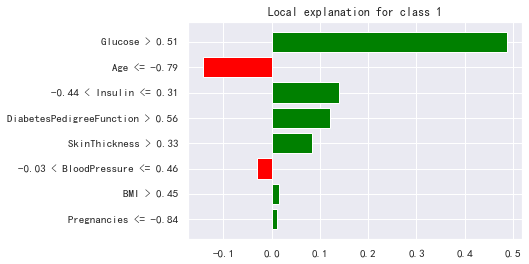

In [306]:
fig = exp.as_pyplot_figure()


<span style="color:blue">--- 小结 ---</span>

&emsp;上面我选择了一个阳性样本来测试，从特征重要性结果图可以看出，Glocose,Insulin对模型预测该病人为阳性起到的作用较大。且这2项指标也确实是患糖尿病的主要因素。
<span style="color:black"> </span>

# 4. Best Model Construction

<span style="color:blue">1) Generate the best classifier you can for predicting the diabetes outcome. Show the classification **accuracy**, **weighted F1** and **confusion matrix** on test data (you should keep the original train test split). Besides that, you can also show any result or plot that are helpful for us to better understand your model. Write a short description of you model indicating the elements that help to improve prediction. You may use any classifier including but not limited to those experimented above. Marks will be given based on your model performance and description. *(13 points)*</span>

<span style="color:blue">*(Hint: you can think about improving the model performance from different aspects: e.g. improve the feature set; choose a more sophisticated classifier such as ensemble models; or improve the training process via careful hyperparameter tunning or sampling techniques.)*</span>



<span style="color:blue">--- Your description here ---</span>

下面就是使用了网格搜索算法来调试出模型的最好参数，并使用10折交叉验证来训练模型。
<span style="color:black">  </span>

In [307]:
# --- Your code here ---
# tuning
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GridSearchCV
param_grid  = {'n_estimators': [100,200,300,400,500],
                'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
                'min_child_weight': [1, 2, 3, 4, 5, 6]}


xgb_model = XGBClassifier()
grid_search = GridSearchCV(xgb_model, param_grid,n_jobs=-1,verbose=2,cv=10)


grid_search.fit(x_train2,y_train2)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[21:17:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weigh

<span style="color:blue">--- Your description here ---</span>

上面得出了最好的模型，下面在测试集上测试一下accuracy和weighted F1指标。
<span style="color:black"> </span>

accuracy为： 0.921875 weighted F1为： 0.9228815285278942


Text(0.5, 50.5, '预测结果')

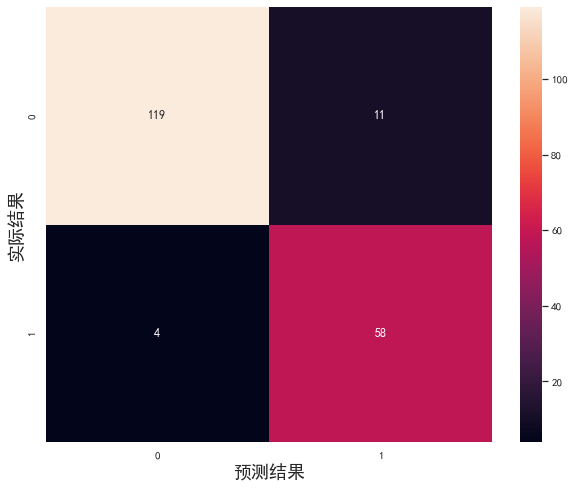

In [308]:
# --- Your code here ---
# best model
xgb_model = grid_search.best_estimator_

y_pred2 = xgb_model.predict(x_test2)
acc = accuracy_score(y_test2, y_pred2)
f1 = f1_score(y_test2, y_pred2, average='weighted')
print('accuracy为：',acc, 'weighted F1为：',f1)
import seaborn as sns

plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置
from sklearn.metrics import accuracy_score, confusion_matrix
conf_mat = confusion_matrix( y_test2, y_pred2)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=[str(i) for i in range(2)],
            yticklabels=[str(i) for i in range(2)])
plt.ylabel('实际结果',fontsize=18)
plt.xlabel('预测结果',fontsize=18)

<span style="color:blue">--- Your description here ---</span>

上面得出的最好的模型的配置参数如下：
<span style="color:black">  </span>

In [309]:
# --- Your code here ---
print('模型参数为：',xgb_model.get_params())

模型参数为： {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 200, 'n_jobs': 16, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


<span style="color:blue">2) Can the final model you constructed be deployed at the hospital to diagnose patients automatically?  How would the doctors explain the prediction results to the patients?  Write down any of your opinions or concerns. *(2 points)*</span>

可以通过下面这种方式将训练好的模型保存下来，然后将其部署到医院的计算机上。

In [310]:
import joblib
#保存训练好的模型
joblib.dump(xgb_model,"./model.pkl")

['./model.pkl']

然后在医院的计算机上，通过下面代码即可加载模型进行预测。

In [311]:
 #导入模型
model=joblib.load("./model.pkl")

可以写个自动化脚本和界面，检测到有样本输入时，执行模型的预测，并输出显示模型对样本预测的结果与解释。
即通过LIME方法对模型的预测结果进行解释，以辅助医生作出医疗诊断。

In [312]:
xgb_model = grid_search.best_estimator_
predict_fn_rf = lambda x: xgb_model.predict_proba(x).astype(float)

# 创建一个LIME解释器
X = x_test2.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names =pima2.columns, class_names = ['0','1'], kernel_width = 5)
#选择一个样本点
chosen_index = x_test2.index[0]
chosen_instance = x_test2.loc[chosen_index].values

# 使用LIME解释器解释数据点
exp = explainer.explain_instance(chosen_instance, predict_fn_rf, num_features = 8)
exp.show_in_notebook(show_all=True)

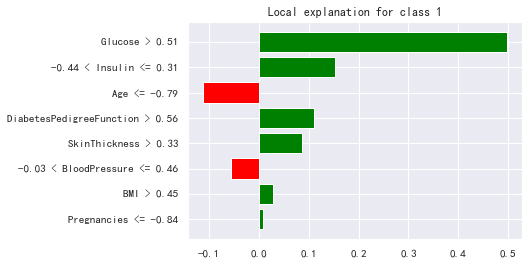

In [313]:
fig = exp.as_pyplot_figure()


<span style="color:blue">--- Your opinion here ---</span>

最后我采用的最优模型是XGB：

【注：上面之所以没用过采样策略是因为我测试了有无过采样，得到的结果差别不大】

accuracy: 92.19%

weighted: 92.29%

通过上述代码和说明，就可以将训练好的最优XGB模型部署到医院计算机上自动化预测并诊断病人的情况，同时模型将会输出显示预测的结果，以及通过LIME算法可以解释为何模型会做出这样的决策，哪些因素对诊断为糖尿病起到了主导作用，这样的显示结果将能够很好的辅助医生诊断，以及展示给病人查阅。
<span style="color:black"> </span>